In [1]:
getwd()
if ( is.null(environment()$this_notebook_dir) ) {
    this_notebook_dir <- getwd()
    setwd(paste0(getwd(), '/..'))
}
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/NA_fix"

[1] "/mnt/hdd/develop/kaggle/house-prices/R"

In [3]:
source('helpers.R')

kaggle.house.loadLibraries()
data <- kaggle.house.loadData()

df.LotFrontage <- data$combined %>% select(-dataSource) %>% filter(!is.na(LotFrontage))

df.LotFrontage.vs.numeric <- df.LotFrontage %>% select_if(is.numeric)

df.LotFrontage.vs.char <- df.LotFrontage %>% 
    select(starts_with('LotFrontage'),  
           which(sapply(df.LotFrontage, is.character)) %>% names)

df.LotFrontage %>% dim
df.LotFrontage.vs.numeric %>% dim
df.LotFrontage.vs.char %>% dim

[1] 2433   79

[1] 2433   35

[1] 2433   45

In [4]:
df.LotFrontage %>% select(-LotFrontage, -Utilities) %>% 
    map(function (col) {  
            lm(LotFrontage ~ attr, tibble(attr=col, LotFrontage=df.LotFrontage$LotFrontage))
    }) -> models.lst

tibble(
    var = names(models.lst),
    mod = models.lst,
    glance = map(mod, broom::glance)
) -> models.df

models.df %>% head(2) %>% print

models.df %>% select(-mod) %>% unnest(glance) %>% arrange(desc(r.squared)) %>% head

# A tibble: 2 x 3
         var      mod                glance
       <chr>   <list>                <list>
1 MSSubClass <S3: lm> <data.frame [1 x 11]>
2   MSZoning <S3: lm> <data.frame [1 x 11]>


var,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
MSSubClass,0.3539728,0.3502324,18.81790,94.6340420,3.433373e-217,15,-10585.14332,21202.2866,21295.0367,856246.0,2418
BldgType,0.2787318,0.2775436,19.84257,234.5732511,1.820384e-170,5,-10719.16444,21450.3289,21485.1102,955970.6,2428
Neighborhood,0.2676187,0.2603192,20.07771,36.6626965,1.468147e-143,25,-10737.76508,21527.5302,21678.2491,970700.0,2408
LotArea,0.2399977,0.2396850,20.35583,767.6744036,4.455289e-147,2,-10782.80015,21571.6003,21588.9909,1007309.0,2431
X1stFlrSF,0.2099907,0.2096658,20.75379,646.1791231,1.315681e-126,2,-10829.90688,21665.8138,21683.2044,1047080.2,2431
PoolQC,0.1712089,-0.1050548,82.69119,0.6197301,5.692922e-01,3,-50.68187,109.3637,110.1526,41027.0,6


In [6]:
df.LotFrontage.vs.char %>%
select(-Utilities) %>%
gather(attr.name, attr.val, -LotFrontage) %>%
group_by(attr.name) %>% 
nest %>% 
mutate(
    mod = map(data, ~lm(LotFrontage ~ attr.val, .)),
    glance = map(mod, broom::glance)
) %>% 
select(-data, -mod) %>% 
unnest(glance) %>%
arrange(desc(r.squared)) %>%
head

attr.name,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
MSSubClass,0.3539728,0.3502324,18.81790,94.6340420,3.433373e-217,15,-10585.14332,21202.2866,21295.0367,856246.03,2418
BldgType,0.2787318,0.2775436,19.84257,234.5732511,1.820384e-170,5,-10719.16444,21450.3289,21485.1102,955970.63,2428
Neighborhood,0.2676187,0.2603192,20.07771,36.6626965,1.468147e-143,25,-10737.76508,21527.5302,21678.2491,970700.03,2408
PoolQC,0.1712089,-0.1050548,82.69119,0.6197301,5.692922e-01,3,-50.68187,109.3637,110.1526,41027.00,6
Alley,0.1587058,0.1541085,16.21692,34.5219924,1.953858e-08,2,-776.91834,1559.8367,1569.4977,48126.87,183
MSZoning,0.1374468,0.1360241,21.67323,96.6052348,2.316218e-76,5,-10920.38758,21852.7752,21887.5490,1139092.89,2425


In [7]:
df.LotFrontage.vs.char %>%
mutate(LotFrontage.log = log(LotFrontage)) %>%
select(-Utilities, -LotFrontage) %>%
gather(attr.name, attr.val, -LotFrontage.log) %>%
group_by(attr.name) %>% 
nest %>% 
mutate(
    mod = map(data, ~lm(LotFrontage.log ~ attr.val, .)),
    glance = map(mod, broom::glance)
) %>% 
select(-data, -mod) %>% 
unnest(glance) %>%
arrange(desc(r.squared)) %>%
head

attr.name,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
MSSubClass,0.5668997,0.56439206,0.2361222,226.0715717,0.000000e+00,15,67.052563,-102.10513,-9.35504,134.812380,2418
BldgType,0.4982173,0.49739059,0.2536321,602.6868716,0.000000e+00,5,-112.013613,236.02723,270.80851,156.191352,2428
Neighborhood,0.4194256,0.41363914,0.2739500,72.4840221,7.064511e-263,25,-289.441012,630.88202,781.60091,180.717058,2408
Alley,0.2272434,0.22302066,0.2978124,53.8145325,6.920491e-12,2,-37.409230,80.81846,90.47953,16.230673,183
MSZoning,0.1853127,0.18396884,0.3230017,137.9005065,2.691946e-106,5,-699.380737,1410.76147,1445.53535,253.000503,2425
PoolQC,0.1761405,-0.09847939,0.5250374,0.6413974,5.591902e-01,3,-5.147282,18.29456,19.08346,1.653986,6


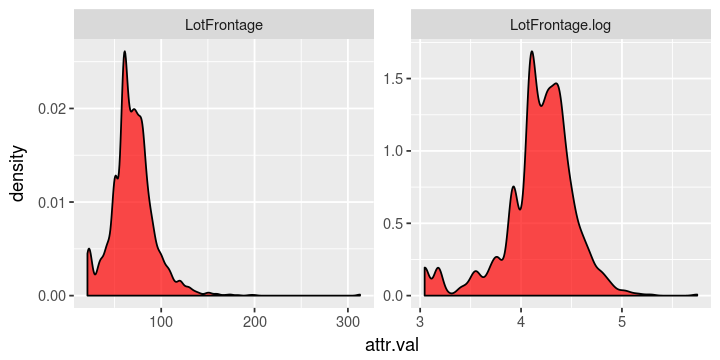

In [8]:
options(repr.plot.width = 6, repr.plot.height = 3)

df.LotFrontage %>% select(LotFrontage) %>% 
mutate(LotFrontage.log = log(LotFrontage)) %>%
gather(attr.name, attr.val) %>%
ggplot() +
geom_density(aes(attr.val), fill = "red", alpha = "0.7") +
facet_wrap(~attr.name, scales="free")

In [9]:
df.LotFrontage %>% 
select(LotFrontage, MSSubClass) %>%
mutate(LotFrontage.log = log(LotFrontage)) %>%
lm(LotFrontage.log ~ MSSubClass, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ MSSubClass, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74116 -0.15002 -0.02235  0.11825  1.42180 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.75802    0.01928 194.925  < 2e-16 ***
MSSubClass160 -0.50398    0.02919 -17.263  < 2e-16 ***
MSSubClass180 -0.52194    0.06210  -8.405  < 2e-16 ***
MSSubClass190  0.42908    0.03674  11.679  < 2e-16 ***
MSSubClass20   0.56638    0.02083  27.185  < 2e-16 ***
MSSubClass30   0.32470    0.02853  11.379  < 2e-16 ***
MSSubClass40   0.20792    0.10734   1.937   0.0529 .  
MSSubClass45   0.24786    0.05890   4.208 2.67e-05 ***
MSSubClass50   0.36105    0.02418  14.934  < 2e-16 ***
MSSubClass60   0.58181    0.02231  26.076  < 2e-16 ***
MSSubClass70   0.37314    0.02912  12.812  < 2e-16 ***
MSSubClass75   0.49990    0.05501   9.087  < 2e-16 ***
MSSubClass80   0.58133    0.03206  18.135  < 2e-16 ***
MSSubClass85   0.51720    0.04598  11.249  < 2e-16 

[1] 134.8124

In [8]:
df.LotFrontage %>% 
select(LotFrontage, MSSubClass) %>%
mutate(LotFrontage.log = log(LotFrontage)) %>%
group_by(MSSubClass) -> df

df %>%
summarise(mean = mean(LotFrontage.log)) %>%
arrange(mean) %>% head(1) %>% `$`("mean") -> minimal_group_mean

df %>%
mutate(MSSubClass.new = mean(LotFrontage.log) - minimal_group_mean) %>% 
lm(LotFrontage.log ~ MSSubClass.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ MSSubClass.new, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74116 -0.15002 -0.02235  0.11825  1.42180 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.23608    0.01740  185.99   <2e-16 ***
MSSubClass.new  1.00000    0.01773   56.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2355 on 2431 degrees of freedom
Multiple R-squared:  0.5669,	Adjusted R-squared:  0.5667 
F-statistic:  3182 on 1 and 2431 DF,  p-value: < 2.2e-16


[1] 134.8124

In [40]:
df.LotFrontage %>% 
select(LotFrontage, MSSubClass) %>%
mutate(LotFrontage.log = log(LotFrontage)) %>%
group_by(MSSubClass) -> df

df %>% ungroup() %>% 
summarise(mean = mean(LotFrontage.log)) %>% `$`("mean") -> total_mean

df %>%
mutate(MSSubClass.new = mean(LotFrontage.log) - total_mean) %>% 
lm(LotFrontage.log ~ MSSubClass.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ MSSubClass.new, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74116 -0.15002 -0.02235  0.11825  1.42180 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.179890   0.004774  875.51   <2e-16 ***
MSSubClass.new 1.000000   0.017728   56.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2355 on 2431 degrees of freedom
Multiple R-squared:  0.5669,	Adjusted R-squared:  0.5667 
F-statistic:  3182 on 1 and 2431 DF,  p-value: < 2.2e-16


[1] 134.8124

In [9]:
df.LotFrontage %>% 
select(LotFrontage, MSSubClass) %>%
mutate(LotFrontage.log = log(LotFrontage)) %>%
group_by(MSSubClass) %>%
mutate(MSSubClass.new = mean(LotFrontage.log)) %>% 
lm(LotFrontage.log ~ MSSubClass.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ MSSubClass.new, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74116 -0.15002 -0.02235  0.11825  1.42180 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -6.742e-14  7.425e-02    0.00        1    
MSSubClass.new  1.000e+00  1.773e-02   56.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2355 on 2431 degrees of freedom
Multiple R-squared:  0.5669,	Adjusted R-squared:  0.5667 
F-statistic:  3182 on 1 and 2431 DF,  p-value: < 2.2e-16


[1] 134.8124

In [10]:
df.LotFrontage %>% 
select(LotFrontage, LotArea) %>%
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
lm(LotFrontage.log ~ LotArea.log, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ LotArea.log, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.33420 -0.12683  0.02732  0.13909  1.25960 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.816932   0.085101    -9.6   <2e-16 ***
LotArea.log  0.551207   0.009374    58.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2299 on 2431 degrees of freedom
Multiple R-squared:  0.5872,	Adjusted R-squared:  0.587 
F-statistic:  3458 on 1 and 2431 DF,  p-value: < 2.2e-16


[1] 128.4953

In [11]:
df.LotFrontage %>% 
select(LotFrontage, LotArea, MSSubClass) %>%
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
group_by(MSSubClass) %>%
mutate(MSSubClass.new = mean(LotFrontage.log)) %>% 
lm(LotFrontage.log ~ LotArea.log + MSSubClass.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.new, 
    data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02441 -0.10275  0.00225  0.10683  1.15100 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.13092    0.07773  -14.55   <2e-16 ***
LotArea.log     0.33310    0.01244   26.78   <2e-16 ***
MSSubClass.new  0.54815    0.02297   23.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.207 on 2430 degrees of freedom
Multiple R-squared:  0.6656,	Adjusted R-squared:  0.6653 
F-statistic:  2418 on 2 and 2430 DF,  p-value: < 2.2e-16


[1] 104.0928

In [10]:
df.LotFrontage %>% 
select(LotFrontage, LotArea, MSSubClass) %>%
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
group_by(MSSubClass) -> df

df %>% ungroup() %>% 
summarise(mean = mean(LotFrontage.log)) %>% `$`("mean") -> total_mean

df %>% 
mutate(MSSubClass.new = mean(LotFrontage.log) - total_mean) %>% 
lm(LotFrontage.log ~ LotArea.log + MSSubClass.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.new, 
    data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02441 -0.10275  0.00225  0.10683  1.15100 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1.16030    0.11284   10.28   <2e-16 ***
LotArea.log     0.33310    0.01244   26.78   <2e-16 ***
MSSubClass.new  0.54815    0.02297   23.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.207 on 2430 degrees of freedom
Multiple R-squared:  0.6656,	Adjusted R-squared:  0.6653 
F-statistic:  2418 on 2 and 2430 DF,  p-value: < 2.2e-16


[1] 104.0928

In [15]:
df.LotFrontage %>% 
select(LotFrontage, LotArea, MSSubClass) %>%
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
lm(LotFrontage.log ~ LotArea.log + MSSubClass, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)

df.LotFrontage %>% 
select(LotFrontage, LotArea, MSSubClass, BldgType, Neighborhood) %>%
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
lm(LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + Neighborhood, data = .) -> model

sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02965 -0.09845  0.00116  0.10641  1.14375 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.87696    0.10829   8.098 8.75e-16 ***
LotArea.log    0.33748    0.01253  26.935  < 2e-16 ***
MSSubClass160 -0.24130    0.02740  -8.806  < 2e-16 ***
MSSubClass180 -0.24097    0.05546  -4.345 1.45e-05 ***
MSSubClass190  0.22774    0.03308   6.884 7.39e-12 ***
MSSubClass20   0.32685    0.02032  16.082  < 2e-16 ***
MSSubClass30   0.20083    0.02545   7.892 4.48e-15 ***
MSSubClass40   0.04072    0.09436   0.431   0.6661    
MSSubClass45   0.15438    0.05178   2.981   0.0029 ** 
MSSubClass50   0.19014    0.02214   8.589  < 2e-16 ***
MSSubClass60   0.32849    0.02171  15.128  < 2e-16 ***
MSSubClass70   0.19911    0.02635   7.556 5.86e-14 ***
MSSubClass75   0.27565    0.04897   5.629 2.02e-08 ***
MSSubClass80   0.34972    0.02940  11

[1] 103.6882

[1] 92.18313

In [14]:
df.LotFrontage %>% 
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
group_by(MSSubClass) %>%
mutate(MSSubClass.new = mean(LotFrontage.log)) %>%
group_by(BldgType) %>%
mutate(BldgType.new = mean(LotFrontage.log)) %>%
group_by(Neighborhood) %>%
mutate(Neighborhood.new = mean(LotFrontage.log)) %>%
lm(LotFrontage.log ~ LotArea.log + MSSubClass.new + BldgType.new + Neighborhood.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.new + 
    BldgType.new + Neighborhood.new, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.93307 -0.10356  0.00261  0.10092  1.13659 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.43308    0.08508 -16.845  < 2e-16 ***
LotArea.log       0.29350    0.01318  22.266  < 2e-16 ***
MSSubClass.new    0.37045    0.03725   9.944  < 2e-16 ***
BldgType.new      0.14215    0.03588   3.962 7.66e-05 ***
Neighborhood.new  0.19371    0.02593   7.470 1.11e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2042 on 2428 degrees of freedom
Multiple R-squared:  0.6747,	Adjusted R-squared:  0.6742 
F-statistic:  1259 on 4 and 2428 DF,  p-value: < 2.2e-16


[1] 101.2443

In [16]:
df.LotFrontage %>% 
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
group_by(MSSubClass) %>%
mutate(MSSubClass.new = median(LotFrontage.log)) %>%
group_by(BldgType) %>%
mutate(BldgType.new = median(LotFrontage.log)) %>%
group_by(Neighborhood) %>%
mutate(Neighborhood.new = median(LotFrontage.log)) %>%
lm(LotFrontage.log ~ LotArea.log + MSSubClass.new + BldgType.new + Neighborhood.new, data = .) -> model

model %>% summary
sum(model$residuals ^ 2)


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.new + 
    BldgType.new + Neighborhood.new, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97849 -0.10343  0.00498  0.09993  1.14624 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.36604    0.08580 -15.921  < 2e-16 ***
LotArea.log       0.28886    0.01313  21.993  < 2e-16 ***
MSSubClass.new    0.33035    0.03369   9.806  < 2e-16 ***
BldgType.new      0.18531    0.03611   5.132  3.1e-07 ***
Neighborhood.new  0.18604    0.02156   8.629  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2035 on 2428 degrees of freedom
Multiple R-squared:  0.6771,	Adjusted R-squared:  0.6766 
F-statistic:  1273 on 4 and 2428 DF,  p-value: < 2.2e-16


[1] 100.5127